# Refitting Literature Relations: $M_{\rm{tot}}$-$T_{\rm{X}}$

This section of the project fits scaling relations to literature datasets, in order to compare previous work to our results.

Here we focus on scaling relations between the total mass of galaxy clusters and groups ($M_{\rm{tot}}$, or $M^{\rm{tot}}_{\Delta}$ within an overdensity radius $R_{\Delta}$) and the cluster/group global X-ray temperature ($T_{\rm{X}}$, or $T_{\rm{X},\Delta}$ within $R_{\Delta}$). If present in a property name, 'ce' means 'core-excised', normally 0.15$R_{500}$. We may also refer to $M_{\rm{tot}}$ as $M_{\rm{hy}}$ or $M_{\rm{WL}}$, for hydrostatic mass and weak-lensing mass respectively. Both ostensibly refer to the total halo mass, but are both affected by different physical and practical considerations.

Relation fits are performed using the XGA interface to the R scaling-relation fitting package LIRA, see the paper for full details. This notebook uses data from the following:
* [Arnaud et al. (2005)](https://ui.adsabs.harvard.edu/abs/2005A%26A...441..893A/abstract) - a set of 10 nearby, relaxed, galaxy clusters with XMM observations. A widely used $M_{tot}$-$T_{\rm{X}}$ relation was included in this paper.
* [Lovisari et al. (2020)](https://ui.adsabs.harvard.edu/abs/2020ApJ...892..102L/abstract) - a set of 120 galaxy clusters selected from the Planck-ESZ catalog, followed up with XMM observations, and then analysed. An $M_{tot}$-$T_{\rm{X}}$ relation was published from this data previously.

## Import Statements

In [1]:
import pandas as pd
import numpy as np
from astropy.units import Quantity
from astropy.cosmology import LambdaCDM

# This adds the directory above to the path, allowing me to import the common functions that I've written in
#  common.py - this just saves me repeating boring code and makes sure its all consistent
import sys
sys.path.insert(0, '..')
from common import lovisari_cosmo, arnaud_cosmo, tx_norm, m_norm

import xga
from xga.relations.fit import scaling_relation_lira

## Normalisation values

These are used when fitting the scaling relations to normalise the data, and are kept the same throughout this entire project:

In [2]:
tx_norm

<Quantity 4. keV>

In [3]:
m_norm

<Quantity 1.e+14 solMass>

## Cosmological models

These are used to calculated the Hubble parameter values applied to some scaling relation parameters - we match the models used by the original analyses, as they will have had effects on the measured property values we are using (small in all likelihood, but still):

### Arnaud et al. (2005)

In [4]:
arnaud_cosmo

LambdaCDM(name=None, H0=<Quantity 70. km / (Mpc s)>, Om0=0.3, Ode0=0.7, Tcmb0=<Quantity 0. K>, Neff=3.04, m_nu=None, Ob0=None)

## Lovisari et al. (2020)

In [5]:
lovisari_cosmo

LambdaCDM(name=None, H0=<Quantity 70. km / (Mpc s)>, Om0=0.3, Ode0=0.7, Tcmb0=<Quantity 0. K>, Neff=3.04, m_nu=None, Ob0=None)

## Loading data files

All datasets to be refit are included in this repository, so we can load in the required data here.

## Arnaud et al. (2005)

Important considerations for this dataset:
* X-ray temperatures were measured within a slightly unusual (compared to other samples) region - [0.1-0.5]$R_{200}$. This will be somewhat similar to the typical core-excised $R_{500}$, or [0.15-1]$R_{500}$, aperture - but not identical.

In [6]:
arnaud_samp = pd.read_csv("../../sample_files/arnaud2005.csv")
arnaud_samp.head(6)

,name,z,Tx,Tx_err,r200,r200_err,m2500,m2500_err,m1000,m1000_err,m500,m500_err,m200,m200_err,robs/r200,delta_obs
0,A1983,0.0442,2.18,0.09,1103,136,0.43,0.09,0.77,0.22,1.09,0.37,1.59,0.61,0.38,1455
1,MKW9,0.0382,2.43,0.24,1006,84,0.41,0.07,0.66,0.14,0.88,0.20,1.20,0.30,0.41,1401
2,A2717,0.0498,2.56,0.06,1096,44,0.45,0.04,0.79,0.08,1.10,0.12,1.57,0.19,0.54,727
3,A1991,0.0586,2.71,0.07,1106,41,0.58,0.05,0.91,0.09,1.20,0.12,1.63,0.18,0.60,655
4,A2597,0.0852,3.67,0.09,1344,49,1.08,0.07,1.69,0.14,2.22,0.22,3.00,0.33,0.57,713
5,A1068,0.1375,4.67,0.11,1635,47,1.47,0.07,2.69,0.16,3.87,0.28,5.68,0.49,0.58,622


In [7]:
arnaud_samp.columns

Index(['name', 'z', 'Tx', 'Tx_err', 'r200', 'r200_err', 'm2500', 'm2500_err',
       'm1000', 'm1000_err', 'm500', 'm500_err', 'm200', 'm200_err',
       'robs/r200', 'delta_obs'],
      dtype='object')

Calculating E(z) values for these clusters:

In [8]:
arnaud_samp['E'] = arnaud_cosmo.efunc(arnaud_samp['z'].values)

### Lovisari et al. (2020)

In [9]:
lovisari_samp = pd.read_csv("../../sample_files/lovisari2020.csv")
lovisari_samp.head(6)

,PLCKESZ,z,M500,M500+,M500-,Mg500,Mg500+,Mg500-,kT,kT+,...,Lbol-,Lbolexc,Lbolexc+,Lbolexc-,NT,fT,Nsb,fsb,Simbad,NED
0,G000.44-41.83,0.165,5.01,0.55,0.48,6.61,0.36,0.33,5.85,0.32,...,0.78,6.36,0.47,0.47,6,1.00,20,1.21,Simbad,NED
1,G002.74-56.18,0.141,4.96,0.43,0.28,5.63,0.21,0.14,5.36,0.12,...,0.49,6.03,0.23,0.23,10,0.94,49,1.08,Simbad,NED
2,G003.90-59.41,0.151,6.94,0.19,0.19,8.65,0.08,0.08,7.06,0.13,...,0.67,11.62,0.43,0.43,10,0.98,63,1.08,Simbad,NED
3,G006.70-35.54,0.089,2.42,0.04,0.03,4.27,0.05,0.08,4.72,0.08,...,0.25,3.98,0.21,0.21,15,1.14,45,1.18,Simbad,NED
4,G006.78+30.46,0.203,17.56,0.28,0.27,32.00,0.24,0.22,14.37,0.12,...,1.74,60.27,0.84,0.84,19,1.26,171,1.62,Simbad,NED
5,G008.44-56.35,0.149,3.61,0.08,0.07,4.64,0.05,0.04,5.12,0.08,...,0.34,4.54,0.22,0.22,8,1.10,41,1.24,Simbad,NED


In [10]:
lovisari_samp.columns

Index(['PLCKESZ', 'z', 'M500', 'M500+', 'M500-', 'Mg500', 'Mg500+', 'Mg500-',
       'kT', 'kT+', 'kT-', 'kTexc', 'kTexc+', 'kTexc-', 'LX', 'LX+', 'LX-',
       'LXexc', 'LXexc+', 'LXexc-', 'Lbol', 'Lbol+', 'Lbol-', 'Lbolexc',
       'Lbolexc+', 'Lbolexc-', 'NT', 'fT', 'Nsb', 'fsb', 'Simbad', 'NED'],
      dtype='object')

Calculating E(z) values for these clusters:

In [11]:
lovisari_samp['E'] = lovisari_cosmo.efunc(lovisari_samp['z'].values)

## Fitting scaling relations

### Arnaud et al. (2005)

#### $M^{\rm{tot}}_{500}$-$T_{\rm{X,[0.1-0.5]200}}$

In [12]:
# Setting up property variables in astropy quantity objects
arn_mtot500 = Quantity(arnaud_samp[['m500', 'm500_err','m500_err']]*1e+14, 'Msun')*arnaud_samp['E'].values[..., None]
arn_tx = Quantity(arnaud_samp[['Tx', 'Tx_err','Tx_err']], 'keV')

arn_mtot500_tx = scaling_relation_lira(arn_mtot500[:, 0], arn_mtot500[:, 1:], arn_tx[:, 0], arn_tx[:, 1:], 
                                       m_norm, tx_norm, y_name=r"$E(z)M^{\rm{tot}}_{500}$", x_name=r"$T_{\rm{X,[0.1-0.5]200}}$", 
                                       dim_hubb_ind=1, point_names=arnaud_samp['name'].values)
arn_mtot500_tx.model_colour = 'silver'
arn_mtot500_tx.author = 'Arnaud et al.'
arn_mtot500_tx.name = r'Arnaud et al. $E(z)M^{\rm{tot}}_{500}$-$T_{\rm{X,[0.1-0.5]200}}$'
arn_mtot500_tx.save("../../outputs/scaling_relations/literature_refits/mtot-tx/arnaud2005_mtot500_tx.xgarel")

R[write to console]: module mix loaded



  |**************************************************| 100%


In [13]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=arn_mtot500_tx.pars[0][0], e=arn_mtot500_tx.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=arn_mtot500_tx.pars[1][0], e=arn_mtot500_tx.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=arn_mtot500_tx.scatter_par[0], e=arn_mtot500_tx.scatter_par[1]))

Slope of 1.711 ± 0.119

Normalisation of 2.582 ± 0.148

Scatter of 0.043 ± 0.025


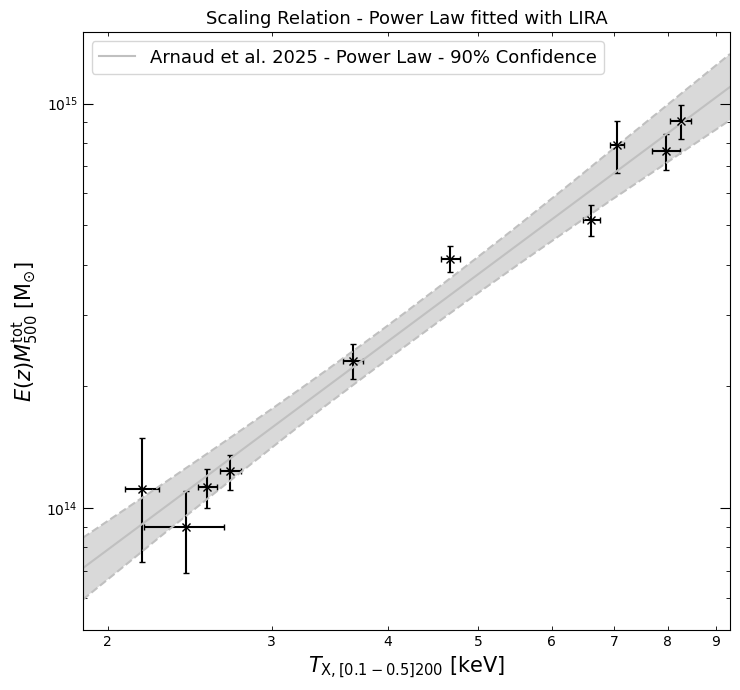

In [14]:
arn_mtot500_tx.view(figsize=(7.5, 7), y_lims=Quantity([5e+13, 1.5e+15], 'Msun'))

#### $M^{\rm{tot}}_{2500}$-$T_{\rm{X,[0.1-0.5]200}}$

In [15]:
# Setting up property variables in astropy quantity objects
arn_mtot2500 = Quantity(arnaud_samp[['m2500', 'm2500_err','m500_err']]*1e+14, 'Msun')*arnaud_samp['E'].values[..., None]
arn_tx = Quantity(arnaud_samp[['Tx', 'Tx_err','Tx_err']], 'keV')

arn_mtot2500_tx = scaling_relation_lira(arn_mtot2500[:, 0], arn_mtot2500[:, 1:], arn_tx[:, 0], arn_tx[:, 1:], 
                                        m_norm, tx_norm, y_name=r"$E(z)M^{\rm{tot}}_{2500}$", x_name=r"$T_{\rm{X,[0.1-0.5]200}}$", 
                                        dim_hubb_ind=1, point_names=arnaud_samp['name'].values)
arn_mtot2500_tx.model_colour = 'black'
arn_mtot2500_tx.author = 'Arnaud et al.'
arn_mtot2500_tx.name = r'Arnaud et al. $E(z)M^{\rm{tot}}_{2500}$-$T_{\rm{X,[0.1-0.5]200}}$'
arn_mtot2500_tx.save("../../outputs/scaling_relations/literature_refits/mtot-tx/arnaud2005_mtot2500_tx.xgarel")

  |**************************************************| 100%


In [16]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=arn_mtot2500_tx.pars[0][0], e=arn_mtot2500_tx.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=arn_mtot2500_tx.pars[1][0], e=arn_mtot2500_tx.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=arn_mtot2500_tx.scatter_par[0], e=arn_mtot2500_tx.scatter_par[1]))

Slope of 1.680 ± 0.136

Normalisation of 1.145 ± 0.074

Scatter of 0.028 ± 0.020


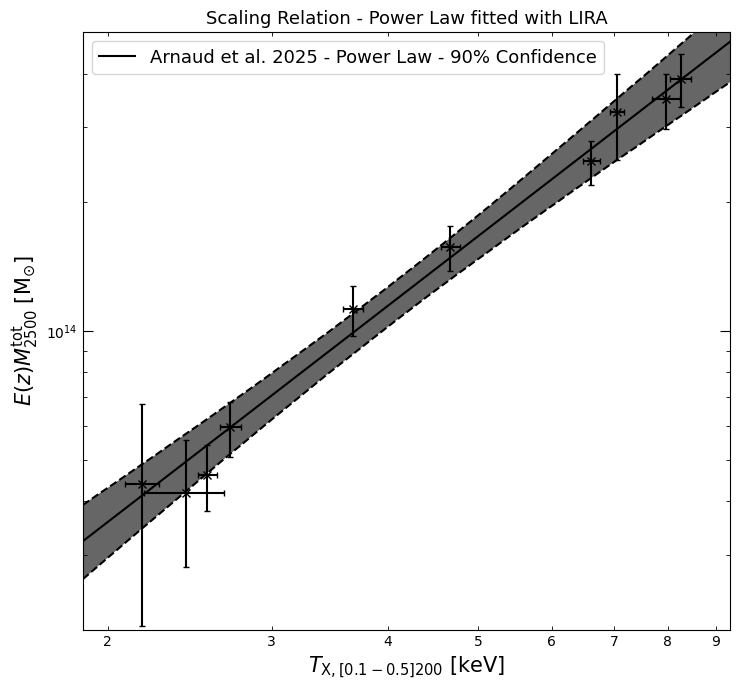

In [17]:
arn_mtot2500_tx.view(figsize=(7.5, 7), y_lims=Quantity([2e+13, 5e+14], 'Msun'))

### Lovisari et al. (2020)

#### $M^{\rm{tot}}_{500}$-$T_{\rm{X,500}}$

In [18]:
# Setting up property variables in astropy quantity objects
lov_mtot500 = Quantity(lovisari_samp[['M500', 'M500-','M500+']]*1e+14, 'Msun')*lovisari_samp['E'].values[..., None]
lov_tx500 = Quantity(lovisari_samp[['kT', 'kT-','kT+']], 'keV')

lov_mtot500_tx500 = scaling_relation_lira(lov_mtot500[:, 0], lov_mtot500[:, 1:], lov_tx500[:, 0], lov_tx500[:, 1:], 
                                          m_norm, tx_norm, y_name=r"$E(z)M^{\rm{tot}}_{500}$", x_name=r"$T_{\rm{X,500}}$", 
                                          dim_hubb_ind=1, point_names=lovisari_samp['PLCKESZ'].values)
lov_mtot500_tx500.model_colour = 'darkolivegreen'
lov_mtot500_tx500.author = "Lovisari et al."
lov_mtot500_tx500.name = r"Lovisari et al. $E(z)M^{\rm{tot}}_{500}$-$T_{\rm{X,500}}$"
lov_mtot500_tx500.save("../../outputs/scaling_relations/literature_refits/mtot-tx/lovisari2020_mtot500_tx500.xgarel")

  |**************************************************| 100%


In [19]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=lov_mtot500_tx500.pars[0][0], e=lov_mtot500_tx500.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=lov_mtot500_tx500.pars[1][0], e=lov_mtot500_tx500.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=lov_mtot500_tx500.scatter_par[0], e=lov_mtot500_tx500.scatter_par[1]))

Slope of 1.602 ± 0.068

Normalisation of 3.088 ± 0.114

Scatter of 0.066 ± 0.006


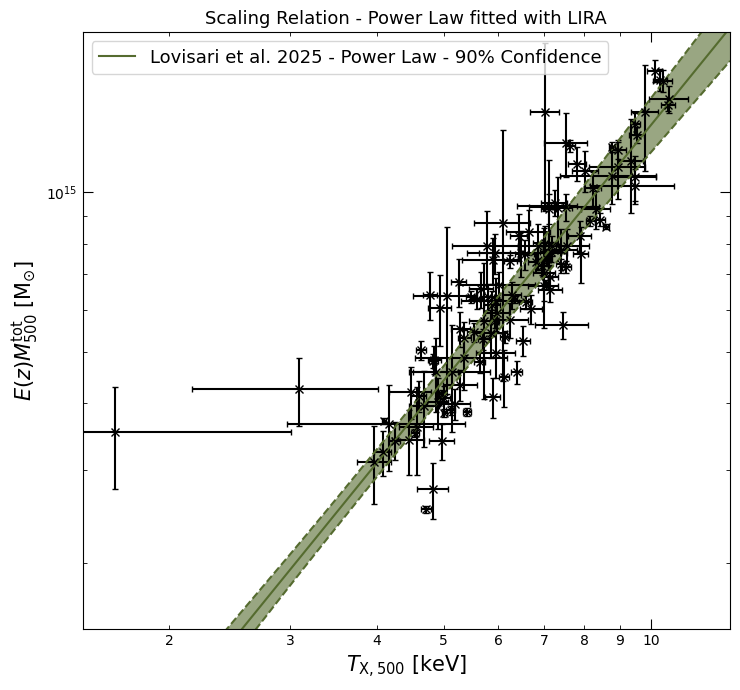

In [20]:
lov_mtot500_tx500.view(figsize=(7.5, 7), y_lims=Quantity([1.5e+14, 2e+15], 'Msun'), x_lims=Quantity([1.5, 13], 'keV')) 

#### $M^{\rm{gas}}_{500}$-$T_{\rm{X,500ce}}$

In [21]:
# Setting up property variables in astropy quantity objects
lov_mtot500 = Quantity(lovisari_samp[['M500', 'M500-','M500+']]*1e+14, 'Msun')*lovisari_samp['E'].values[..., None]
lov_tx500ce = Quantity(lovisari_samp[['kTexc', 'kTexc-','kTexc+']], 'keV')

lov_mtot500_tx500ce = scaling_relation_lira(lov_mtot500[:, 0], lov_mtot500[:, 1:], lov_tx500ce[:, 0], lov_tx500ce[:, 1:], 
                                            m_norm, tx_norm, y_name=r"$E(z)M^{\rm{tot}}_{500}$", x_name=r"$T_{\rm{X,500ce}}$", 
                                            dim_hubb_ind=1, point_names=lovisari_samp['PLCKESZ'].values)
lov_mtot500_tx500ce.model_colour = 'darkseagreen'
lov_mtot500_tx500ce.author = "Lovisari et al."
lov_mtot500_tx500ce.name = r"Lovisari et al. $E(z)M^{\rm{tot}}_{500}$-$T_{\rm{X,500ce}}$"
lov_mtot500_tx500ce.save("../../outputs/scaling_relations/literature_refits/mtot-tx/lovisari2020_mtot500_tx500ce.xgarel")

  |**************************************************| 100%


In [22]:
print("Slope of {v:.3f} ± {e:.3f}\n".format(v=lov_mtot500_tx500ce.pars[0][0], e=lov_mtot500_tx500ce.pars[0][1]))
print("Normalisation of {v:.3f} ± {e:.3f}\n".format(v=lov_mtot500_tx500ce.pars[1][0], e=lov_mtot500_tx500ce.pars[1][1]))
print("Scatter of {v:.3f} ± {e:.3f}".format(v=lov_mtot500_tx500ce.scatter_par[0], e=lov_mtot500_tx500ce.scatter_par[1]))

Slope of 1.603 ± 0.066

Normalisation of 3.111 ± 0.112

Scatter of 0.063 ± 0.006


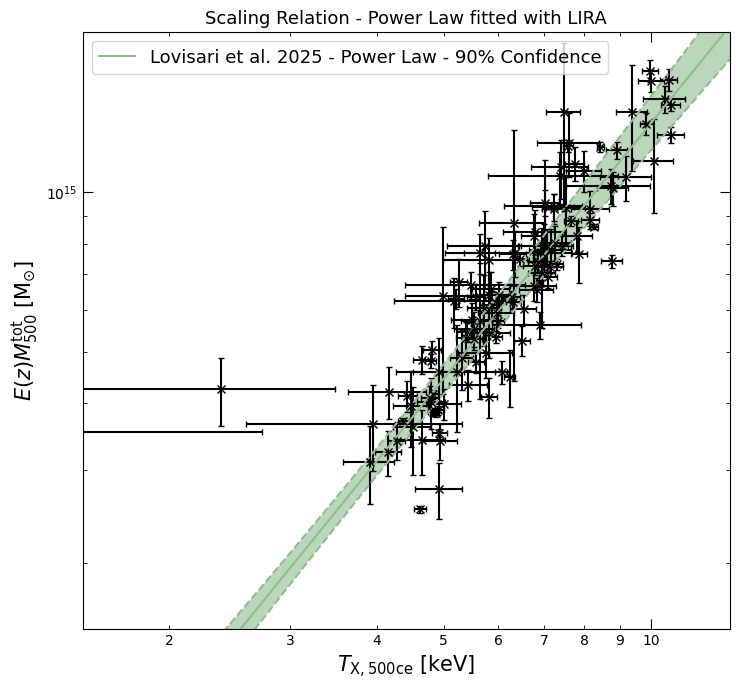

In [23]:
lov_mtot500_tx500ce.model_colour = 'darkseagreen'
lov_mtot500_tx500ce.view(figsize=(7.5, 7), y_lims=Quantity([1.5e+14, 2e+15], 'Msun'), x_lims=Quantity([1.5, 13], 'keV'))

#### Combined contours

/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/products/relation.py:1250: UserWarning: Not all of these ScalingRelations have the same y-axis names.
  warn('Not all of these ScalingRelations have the same y-axis names.')
/Users/dt237/software/anaconda3/envs/xga_env/lib/python3.12/site-packages/xga/products/relation.py:1243: UserWarning: Not all of these ScalingRelations have the same x-axis names.
  warn('Not all of these ScalingRelations have the same x-axis names.')


Removed no burn in
Removed no burn in
Removed no burn in
Removed no burn in


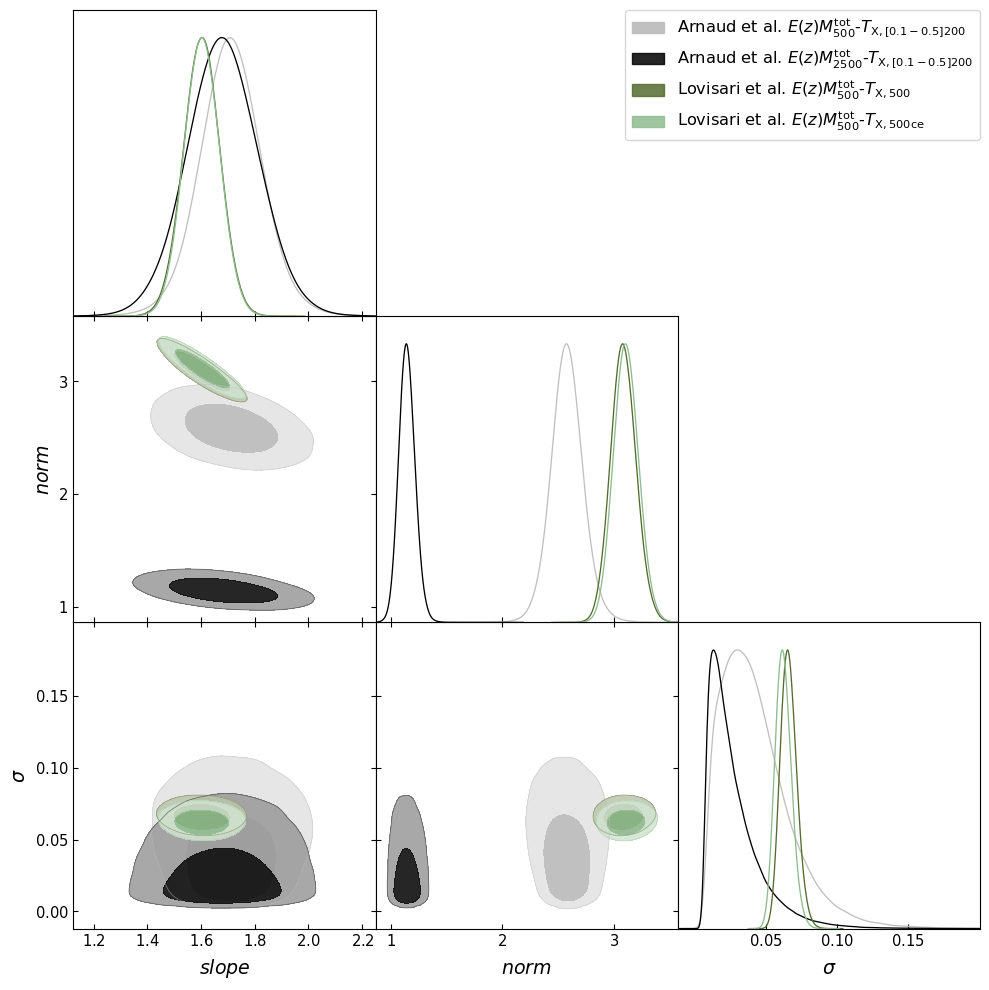

In [24]:
(arn_mtot500_tx + arn_mtot2500_tx + lov_mtot500_tx500 + lov_mtot500_tx500ce).view_corner()